In [1]:
import glob
import json
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

%matplotlib inline

# Add src/ path to get other scripts
cwd = Path(os.path.abspath(os.getcwd()))
sys.path.append(os.path.join(cwd.parent.absolute()))

import helpers.utilities as utils

logger = utils.create_logger()

def print_as_json(dictionary):
    print(json.dumps(dictionary, indent=4, ensure_ascii=False))

Load all PB files from `/src/analytics/pb_files directory`

In [3]:
path_main = os.path.join(cwd, "pb_files", "*.pb")

# Needed for additional files (like not-ready yet)
path_extra = os.path.join(cwd, "pb_files", "a_extra", "*.pb")

files = glob.glob(path_main) + glob.glob(path_extra)

counter = 0
all_files = {}

for pb_file in files:
    filename = os.path.basename(pb_file)
    counter += 1
    if counter % 100 == 0:
        logger.info(f"Loaded {counter} files...")
    meta, projects, votes, _, _ = utils.load_pb_file(pb_file)
    all_files[filename] = [meta, projects, votes]

logger.info(f"Finished. Loaded {counter} .pb files.")

16:36:50 | Pabulib | INFO     - Loaded 100 files...
| __main__:<module>:15 
16:36:51 | Pabulib | INFO     - Loaded 200 files...
| __main__:<module>:15 
16:36:52 | Pabulib | INFO     - Loaded 300 files...
| __main__:<module>:15 
16:36:54 | Pabulib | INFO     - Loaded 400 files...
| __main__:<module>:15 
16:36:55 | Pabulib | INFO     - Loaded 500 files...
| __main__:<module>:15 
16:36:57 | Pabulib | INFO     - Loaded 600 files...
| __main__:<module>:15 
16:36:58 | Pabulib | INFO     - Loaded 700 files...
| __main__:<module>:15 
16:36:58 | Pabulib | INFO     - Loaded 800 files...
| __main__:<module>:15 
16:36:59 | Pabulib | INFO     - Loaded 900 files...
| __main__:<module>:15 
16:37:01 | Pabulib | INFO     - Loaded 1000 files...
| __main__:<module>:15 
16:37:03 | Pabulib | INFO     - Loaded 1100 files...
| __main__:<module>:15 
16:37:05 | Pabulib | INFO     - Loaded 1200 files...
| __main__:<module>:15 
16:37:08 | Pabulib | INFO     - Loaded 1300 files...
| __main__:<module>:15 
16:37:08

Porównanie wysokości BO w 10 największych polskich miastach

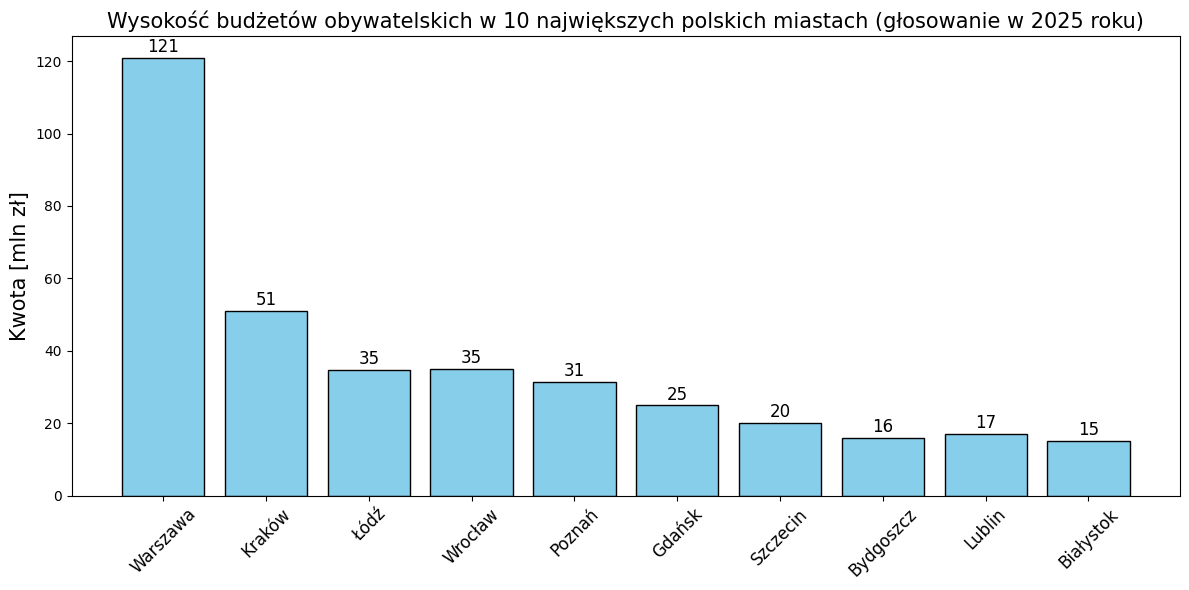

In [17]:
# other cities, głosowanie w 2025 roku
bo_10_miasta = {
    # https://um.warszawa.pl/waw/bo/kwoty-12-edycja
    "Warszawa": 120_934_078,
    # https://budzet.krakow.pl/aktualnosci/290844,1909,komunikat,srodki_na_budzet_obywatelski_miasta_krakowa_2025.html
    "Kraków": 51_000_000,
    # https://uml.lodz.pl/budzet-obywatelski/lbo-2025/2026/podzial-srodkow-w-ramach-lbo/
    "Łódź": 34_650_000,
    # https://www.radiowroclaw.pl/articles/view/148257/Wroclawski-Budzet-Obywatelski-2025-Ostatnia-szansa-na-zgloszenie-projektu-Jak-to-zrobic
    "Wrocław": 35_000_000,
    # https://pbo26.um.poznan.pl/
    "Poznań": 31_300_000,
    # https://www.gdansk.pl/wiadomosci/Wystartowal-Budzet-Obywatelski-2026-Zglos-projekt-i-ulepszaj-Gdansk,a,281031
    "Gdańsk": 24_911_819,
    # https://konsultuj.szczecin.pl/chapter_116342.asp
    "Szczecin": 20_000_000,
    # https://www.bydgoszcz.pl/aktualnosci/tresc/rusza-nowa-edycja-bydgoskiego-budzetu-obywatelski/
    "Bydgoszcz": 16_000_000,
    # https://radio.lublin.pl/2025/06/budzet-obywatelski-lublina-wiemy-ile-projektow-powalczy-o-glosy-mieszkancow/
    "Lublin": 17_000_000,
    # https://www.bialystok.pl/pl/wiadomosci/aktualnosci/13-edycja-budzetu-obywatelskiego.html
    "Białystok": 15_000_000
}

# Przekształcenie wartości na miliony złotych
cities = list(bo_10_miasta.keys())
values_mln = [v / 1_000_000 for v in bo_10_miasta.values()]

# Tworzenie wykresu
plt.figure(figsize=(12, 6))
bars = plt.bar(cities, values_mln, color='skyblue', edgecolor='black')
plt.ylabel("Kwota [mln zł]", fontsize=15)
plt.title("Wysokość budżetów obywatelskich w 10 największych polskich miastach (głosowanie w 2025 roku)", fontsize=15)

# Dodanie wartości nad słupkami
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f"{round(height):,}".replace(',', ' '), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_pb_budget_by_instance(
    all_files,
    city_name="Warszawa",
    shift_instance_year=0,
    extra_data=None
):
    budgets_by_instance = defaultdict(int)
    projects_by_instance = defaultdict(int)
    votes_by_instance = defaultdict(int)

    for records in all_files.values():
        meta = records[0]
        if meta['unit'] != city_name:
            continue
        try:
            year = str(int(meta['instance']) + shift_instance_year)
            budget = round(float(meta['budget']))
            projects = int(meta['num_projects'])
            votes = int(meta['num_votes'])

            budgets_by_instance[year] += budget
            projects_by_instance[year] += projects
            votes_by_instance[year] += votes
        except (KeyError, ValueError):
            continue

    if extra_data:
        for year, budget in extra_data.items():
            budgets_by_instance[str(year)] += budget

    # Sortowanie
    budgets_by_instance = dict(sorted(budgets_by_instance.items()))
    years = list(budgets_by_instance.keys())
    budgets_mln = [budgets_by_instance[y] / 1_000_000 for y in years]

    # Pozycje na osi X
    x_positions = list(range(len(years)))

    plt.figure(figsize=(10, 6))
    plt.plot(x_positions, budgets_mln, marker='o', label=city_name)
    plt.xticks(x_positions, years)
    plt.title(f"Budżet obywatelski {city_name} ({years[0]}–{years[-1]})")
    plt.ylabel("Kwota [mln zł]")
    plt.xlabel("Rok (głosowania)")
    # plt.grid(True)

    # Etykiety słupków
    for x, y in zip(x_positions, budgets_mln):
        plt.text(x, y + 1, f"{y:.1f}", ha='center')

    # Linia między 2018 a 2019 (czyli np. przy x=2.5)
    if "2018" in years and "2019" in years:
        idx_2018 = years.index("2018")
        idx_2019 = years.index("2019")
        midpoint = (idx_2018 + idx_2019) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=1, alpha=0.7)
        plt.text(midpoint + 0.05, max(budgets_mln) * 0.85, "Wprowadzenie ustawy",
                color='red', ha='left', va='top', rotation=90, fontsize=9)

    plt.tight_layout()
    plt.show()


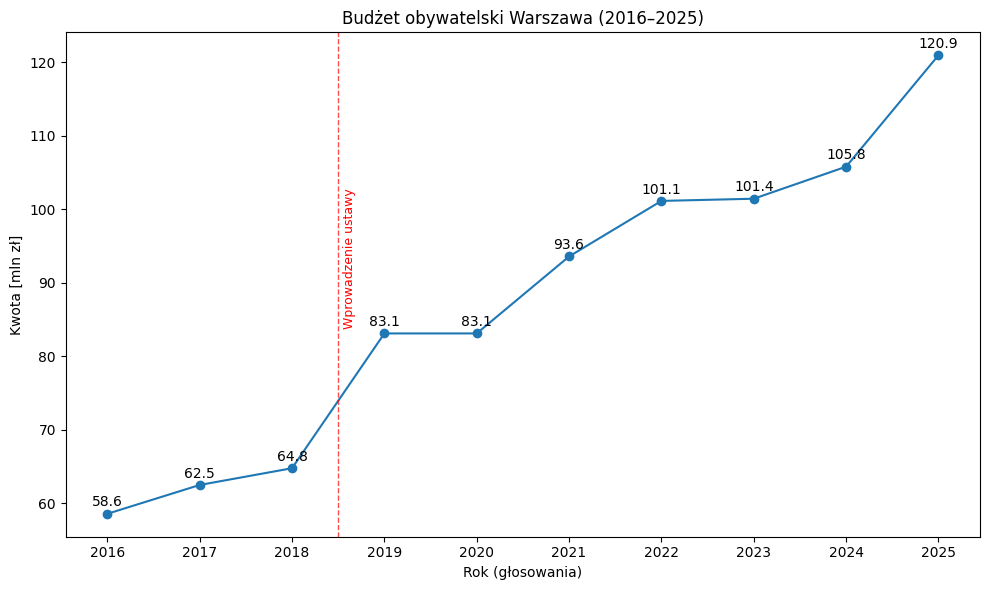

In [20]:
# Warszawa – głosowanie rok wcześniej niż realizacja
plot_pb_budget_by_instance(all_files, city_name="Warszawa", shift_instance_year=-1)

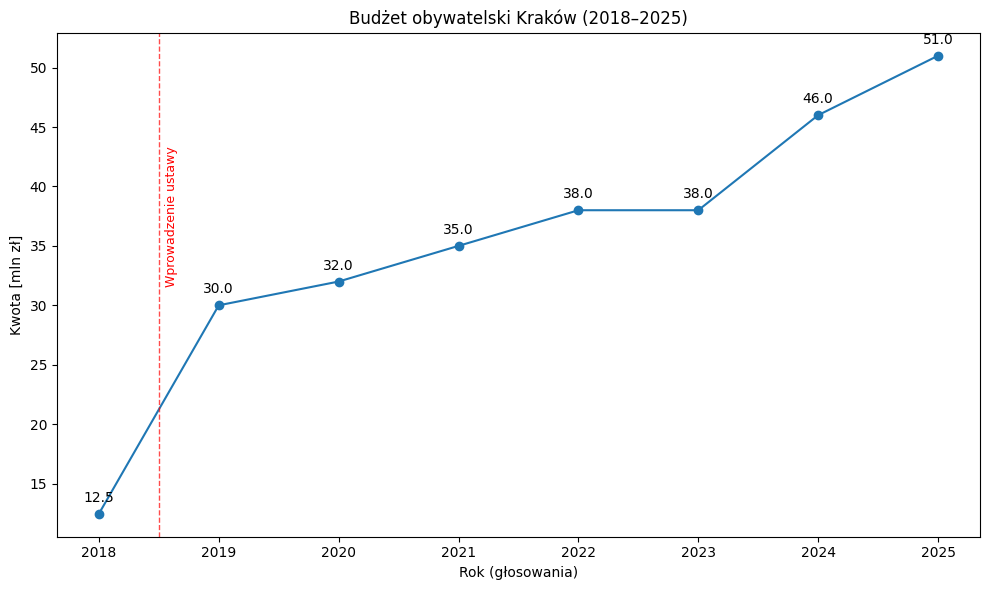

In [21]:
# Kraków – dane z plików + ręczne uzupełnienie 2025
city = "Kraków"
plot_pb_budget_by_instance(all_files, city_name=city, extra_data={"2025": bo_10_miasta[city]})

In [ ]:
# Ile instancji było w danym roku w Warszawie?

files_per_year = defaultdict(int)

for records in all_files.values():
    meta = records[0]
    if meta['unit'] == 'Warszawa':
        # rok głosowania
        year = int(meta['instance']) - 1
        files_per_year[year] += 1

# Konwersja do zwykłego słownika
files_per_year = dict(files_per_year)

# Posortowanie po roku jako liczbie całkowitej
files_per_year_sorted = dict(sorted(files_per_year.items(), key=lambda x: int(x[0])))

files_per_year_sorted

{2016: 86,
 2017: 92,
 2018: 90,
 2019: 19,
 2020: 19,
 2021: 19,
 2022: 19,
 2023: 19,
 2024: 19,
 2025: 75}

In [ ]:
warszawa_submitted_projects = {
    # Source: https://warszawa.eska.pl/budzet-obywatelski-w-warszawie-ile-projektow-zlozyli-mieszkancy-aa-3ZNg-1Y6f-QTC8.html
    "2016": 2649,
    2017: 2782,
    2018: 2433,
    2019: 2166,
    2020: 2243,
    2021: 2199,
    2022: 1943,
    # https://www.raportwarszawski.pl/artykul/2940,budzet-obywatelski-warszawy-po-reformie-mieszkancy-zglosili-wiecej-projektow-ale-sporo-odrzucono
    2023: 1747,
    # Source: https://www.raportwarszawski.pl/artykul/2940,budzet-obywatelski-warszawy-po-reformie-mieszkancy-zglosili-wiecej-projektow-ale-sporo-odrzucono
    2024: 1833,
    2025: 2200
}

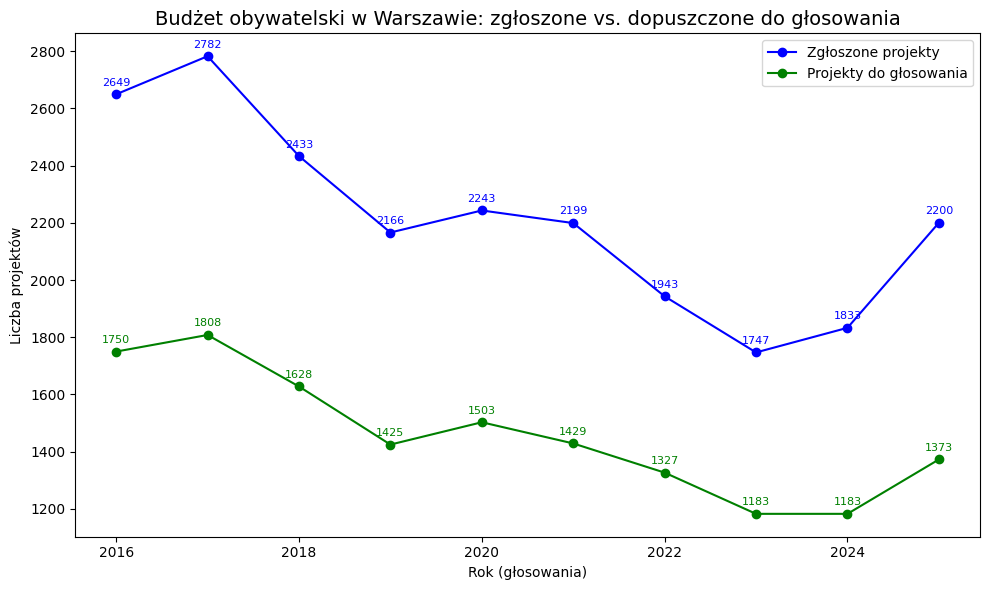

In [26]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Słownik do zliczania projektów
projects_per_year = defaultdict(int)

# Przetwarzanie plików tylko dla Warszawy
for records in all_files.values():
    meta = records[0]
    if meta['unit'] == 'Warszawa':
        year = int(meta['instance']) - 1  # rok głosowania
        projects = int(meta['num_projects'])
        projects_per_year[year] += projects

# Wspólne lata do porównania
all_years = sorted(set(projects_per_year.keys()) | set(warszawa_submitted_projects.keys()))

# Przygotowanie danych do wykresu
submitted = [warszawa_submitted_projects.get(y, None) for y in all_years]
available = [projects_per_year.get(y, None) for y in all_years]

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(all_years, submitted, marker='o', color='blue', label='Zgłoszone projekty')
plt.plot(all_years, available, marker='o', color='green', label='Projekty do głosowania')

# Dodanie wartości nad punktami (jeśli dane istnieją)
for x, y in zip(all_years, submitted):
    if y is not None:
        plt.text(x, y + 30, str(y), ha='center', fontsize=8, color='blue')

for x, y in zip(all_years, available):
    if y is not None:
        plt.text(x, y + 30, str(y), ha='center', fontsize=8, color='green')

plt.title("Budżet obywatelski w Warszawie: zgłoszone vs. dopuszczone do głosowania", fontsize=14)
plt.xlabel("Rok (głosowania)")
plt.ylabel("Liczba projektów")
plt.legend()
plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()



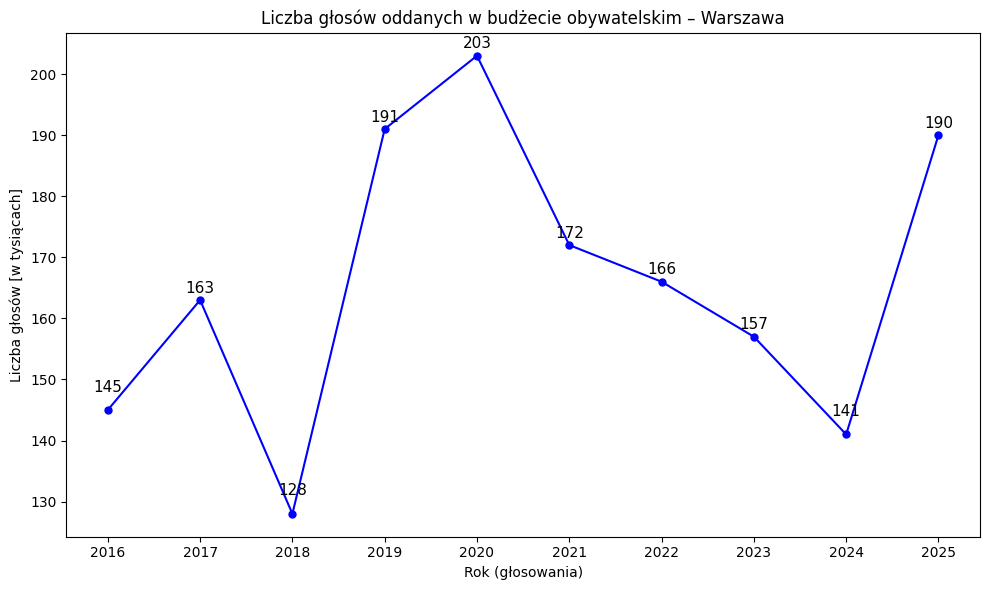

In [25]:
# Słownik do zliczania głosów
votes_per_year = defaultdict(int)

# Przetwarzanie plików tylko dla Warszawy
for records in all_files.values():
    meta = records[0]
    if meta['unit'] == 'Warszawa':
        try:
            year = str(int(meta['instance']) - 1)  # rok głosowania
            votes = int(meta['num_votes'])
            votes_per_year[year] += votes
        except (KeyError, ValueError):
            continue

# Posortowane lata i dane
years = sorted(votes_per_year.keys(), key=int)
votes = [votes_per_year[y] for y in years]

# Przeskaluj wartości do tysięcy
votes_in_thousands = [int(v / 1000) for v in votes]  # pełne tysiące

# Wykres
plt.figure(figsize=(10, 5))
plt.plot(years, votes_in_thousands, marker='o', color='blue', markersize=5)

# Dodaj wartości nad kropkami (zachowując skalę tysięcy)
for x, y in zip(years, votes_in_thousands):
    offset = 3 if y < 150 else 1.2
    plt.text(x, y + offset, f"{int(y)}", ha='center', fontsize=11)


plt.title("Liczba głosów oddanych w budżecie obywatelskim – Warszawa")
plt.xlabel("Rok (głosowania)")
plt.ylabel("Liczba głosów [w tysiącach]")
plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()


{'2016': 108447, '2017': 116438, '2018': 88973, '2019': 105534, '2020': 108376, '2021': 92297, '2022': 87942, '2023': 84125, '2024': 75021, '2025': 72524}


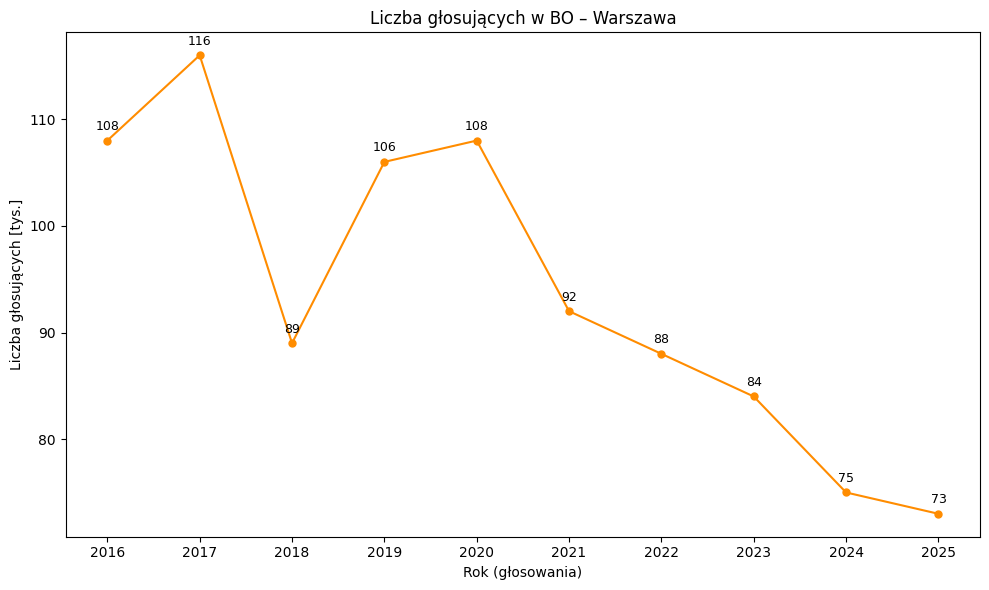

In [29]:
voters_per_year = defaultdict(set)

for records in all_files.values():
    meta = records[0]
    votes = records[2]  # teraz słownik: voter_id -> {'vote': ...}

    if meta.get('unit') == 'Warszawa':
        try:
            year = str(int(meta['instance']) - 1)  # rok głosowania
            for voter_id in votes.keys():
                voters_per_year[year].add(voter_id)
        except (KeyError, ValueError):
            continue

# Przeliczenie na liczby
voters_count_per_year = {
    year: len(voters) for year, voters in voters_per_year.items()
}
print(voters_count_per_year)
voters_count_per_year = dict(sorted(voters_count_per_year.items(), key=lambda x: int(x[0])))

# Zaokrąglenie do pełnych tysięcy
rounded_voters = {
    year: round(count, -3) for year, count in voters_count_per_year.items()
}

# Dane do wykresu
years = list(rounded_voters.keys())
voters_thousands = [v / 1000 for v in rounded_voters.values()]

# Rysowanie wykresu
plt.figure(figsize=(10, 6))
plt.plot(years, voters_thousands, marker='o', color='darkorange', markersize=5)

for x, y in zip(years, voters_thousands):
    plt.text(x, y + 1, f"{int(y)}", ha='center', fontsize=9)

plt.title("Liczba głosujących w BO – Warszawa")
plt.xlabel("Rok (głosowania)")
plt.ylabel("Liczba głosujących [tys.]")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [12]:
# voter_id → liczba plików, w których się pojawił (dla 2025)
voter_file_counts = defaultdict(set)

for filename, records in all_files.items():
    meta = records[0]
    votes = records[2]

    if meta.get('unit') == 'Warszawa' and meta.get('instance') == '2026':
        for voter_id in votes.keys():
            if voter_id:
                voter_file_counts[voter_id].add(filename)

# Teraz liczymy ile razy każdy voter_id się pojawił
voter_participation_counts = Counter(len(files) for files in voter_file_counts.values())

# Posortowany wynik: ilu głosowało w 1, 2, 3... plikach
voter_participation_summary = dict(sorted(voter_participation_counts.items()))
print(voter_participation_summary)

{1: 8370, 2: 9916, 3: 54238}


In [73]:
def plot_vote_distribution(all_files, unit, instance, description_filter=None, negate_description=False, title=None, min_projects=None):
    vote_lengths = Counter()

    for records in all_files.values():
        meta = records[0]
        votes = records[2]

        # Filtr: jednostka i instancja
        if meta.get('unit') == unit and meta.get('instance') == instance:

            # Filtr na minimalną liczbę projektów (jeśli podano)
            if min_projects is not None and int(meta['num_projects']) < min_projects:
                continue

            # Filtr na description, jeśli został przekazany
            if description_filter:
                description = meta.get("description", "").lower()
                filter_text = description_filter.lower()
                if negate_description:
                    if filter_text in description:
                        continue
                else:
                    if filter_text not in description:
                        continue

            for vote_data in votes.values():
                selected = vote_data.get('vote', '')
                if selected:
                    num_selected = len(selected.split(','))
                    key = '15+' if num_selected > 15 else num_selected
                    vote_lengths[key] += 1

    # Obliczenie średniej długości głosu
    total_votes = sum(vote_lengths.values())
    # Uwaga: '15+' traktowane jako 16 w obliczeniach średniej długości głosu
    total_selected_projects = sum(
        (length if isinstance(length, int) else 16) * count
        for length, count in vote_lengths.items()
    )
    average_length = total_selected_projects / total_votes if total_votes > 0 else 0
    print(f"Średnia długość głosu: {average_length:.2f}")

    # Wykres
    lengths = sorted([k for k in vote_lengths if isinstance(k, int)]) + [k for k in vote_lengths if isinstance(k, str)]

    counts = [vote_lengths[l] for l in lengths]

    plt.figure(figsize=(8, 5))
    x_pos = list(range(len(lengths)))
    plt.bar(x_pos, counts, color='skyblue', edgecolor='black')
    plt.xticks(x_pos, [str(l) for l in lengths])

    year = int(instance) - 1

    if unit == "Warszawa":
        year =- 1


    if not title:
        title = f"Rozkład długości pojedynczych głosów - {unit} (głosowanie w {year})"
    
    plt.xlabel("Liczba wybranych projektów w jednym głosie")
    plt.ylabel("Liczba głosów")
    plt.title(title)
    plt.tight_layout()
    plt.show()



Średnia długość głosu: 4.43


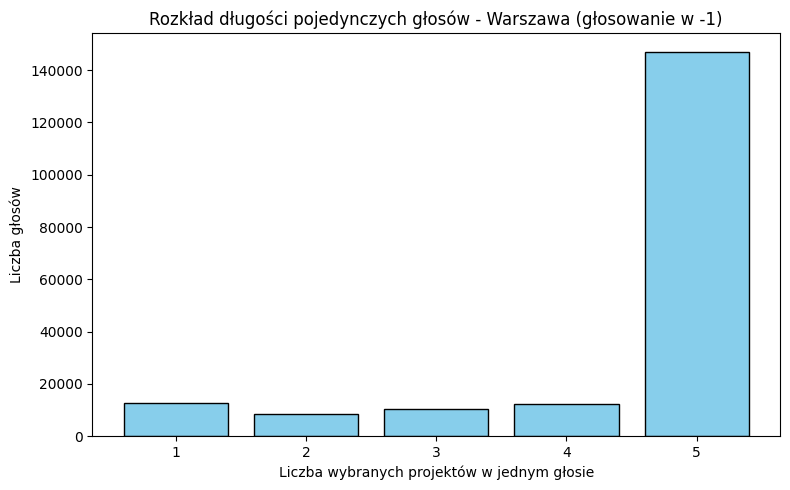

In [74]:
plot_vote_distribution(all_files, 'Warszawa', '2026')

Średnia długość głosu: 8.55


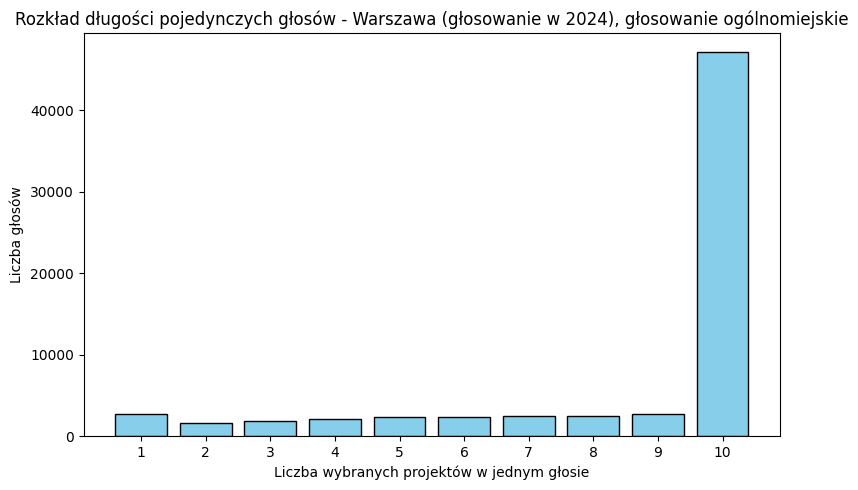

In [75]:
title = "Rozkład długości pojedynczych głosów - Warszawa (głosowanie w 2024), głosowanie ogólnomiejskie"

plot_vote_distribution(all_files, 'Warszawa', '2025', description_filter="municipal", title=title)

Średnia długość głosu: 10.63


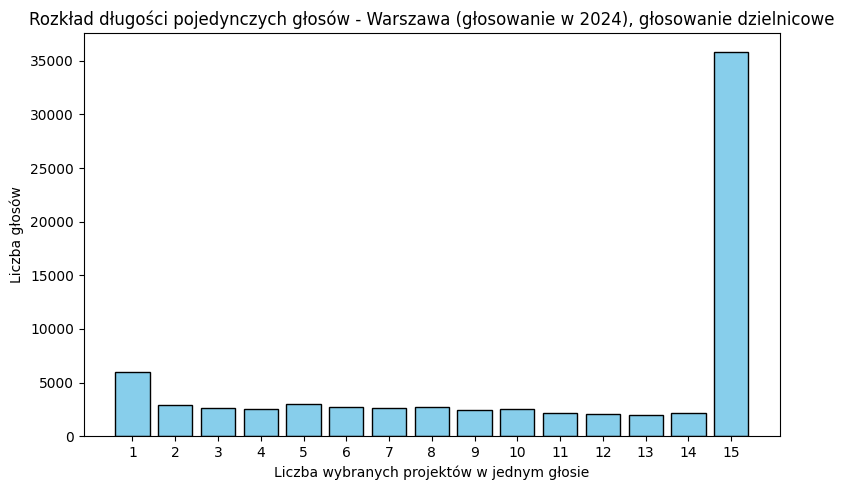

In [76]:
title = "Rozkład długości pojedynczych głosów - Warszawa (głosowanie w 2024), głosowanie dzielnicowe"

plot_vote_distribution(all_files, 'Warszawa', '2025', description_filter="municipal", negate_description=True, title=title)

Średnia długość głosu: 2.41


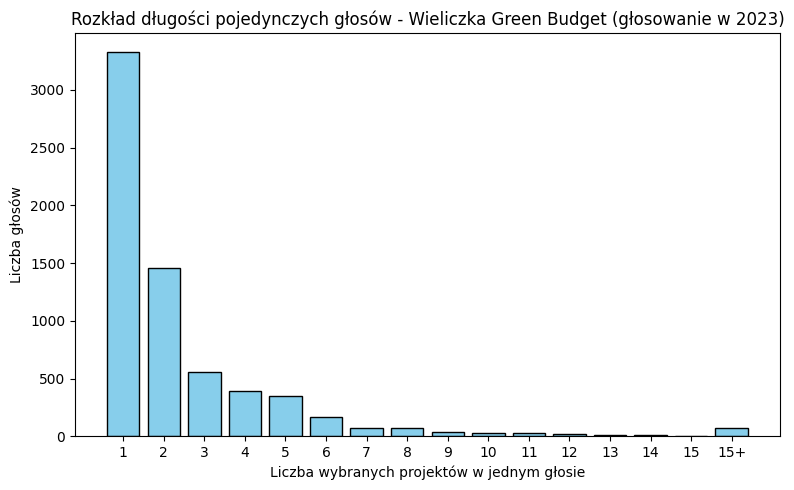

In [77]:
title = "Rozkład długości pojedynczych głosów - Wieliczka Green Budget (głosowanie w 2023)"
plot_vote_distribution(all_files, 'Wieliczka', '2023', title=title)

Średnia długość głosu: 3.39


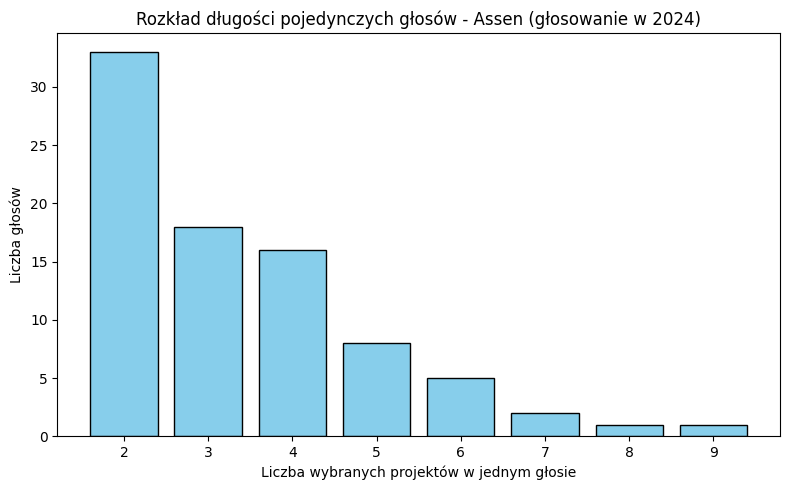

In [83]:
title = "Rozkład długości pojedynczych głosów - Assen (głosowanie w 2024)"
plot_vote_distribution(all_files, 'Assen', '2024', title=title)

Średnia długość głosu: 1.28


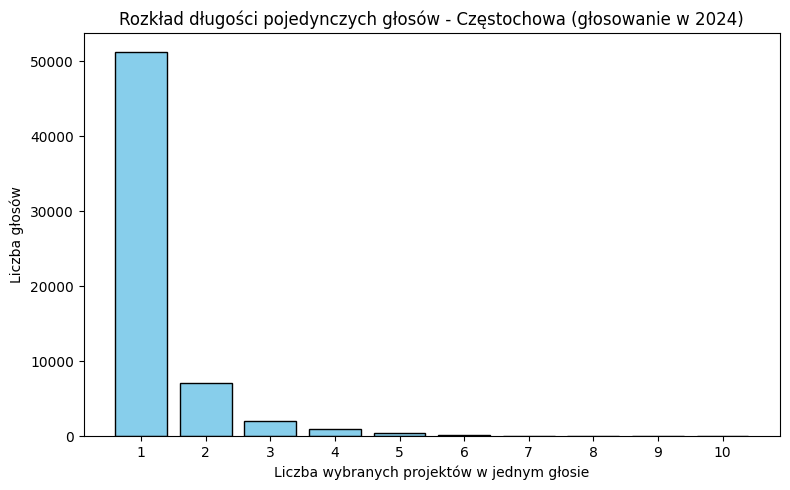

In [90]:
title = "Rozkład długości pojedynczych głosów - Częstochowa (głosowanie w 2024)"
plot_vote_distribution(all_files, 'Częstochowa', '2025', title=title)

Średnia długość głosu: 1.44


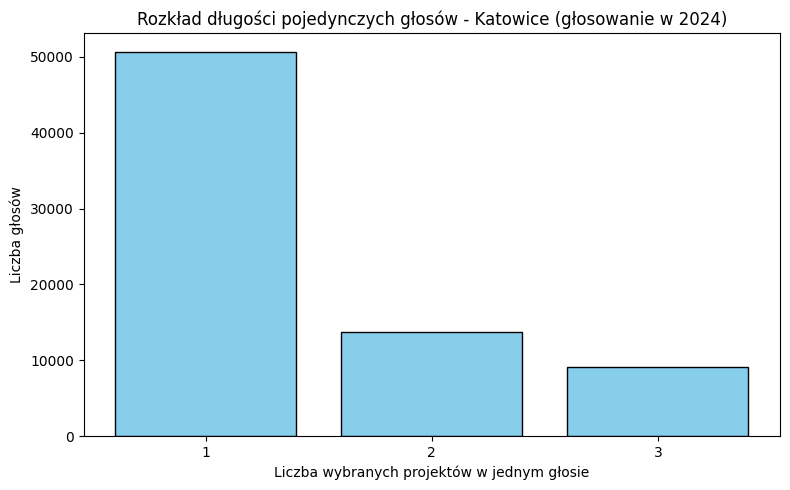

In [91]:
title = "Rozkład długości pojedynczych głosów - Katowice (głosowanie w 2024)"
plot_vote_distribution(all_files, 'Katowice', '2024', title=title)

In [ ]:
def get_vote_details(all_files):
    # Przechowywanie wyników (zbiorem usuwamy duplikaty)
    results = set()

    # Tworzymy słownik do przechowywania maksymalnych lat dla każdego miasta
    max_year_per_city = {}

    # Iterujemy po wszystkich plikach, aby znaleźć maksymalny rok dla każdego miasta
    for records in all_files.values():
        meta = records[0]

        # Sprawdzamy, czy kraj to Polska
        if meta["country"] == "Poland":
            city = meta["unit"]
            instance = int(meta["instance"])

            # Jeśli nie mamy jeszcze maksymalnego roku dla miasta, ustawiamy go
            if city not in max_year_per_city or instance > max_year_per_city[city]:
                max_year_per_city[city] = instance

    # Teraz iterujemy po danych jeszcze raz, by znaleźć szczegóły dla każdego miasta i jego maksymalnego roku
    for records in all_files.values():
        meta = records[0]

        # Sprawdzamy, czy kraj to Polska
        if meta["country"] == "Poland":
            city = meta["unit"]
            instance = int(meta["instance"])

            # Jeśli instancja to maksymalny rok dla miasta, dodajemy wynik
            if instance == max_year_per_city.get(city):
                rule = meta["rule"]
                vote_type = meta["vote_type"]
                # Dodajemy wynik do zbioru, co automatycznie usuwa duplikaty
                results.add((instance, city, rule, vote_type))

    for result in sorted(results):
        print(f"{result[0]} - {result[1]} - {result[2]} - {result[3]}")


In [27]:
get_vote_details(all_files)

2020 - Gdańsk - greedy - choose-1
2020 - Gdańsk - greedy - cumulative
2020 - Gdynia - greedy - approval
2021 - Zabrze - greedy - choose-1
2023 - Wieliczka - equalshares/add1 - approval
2023 - Świecie - equalshares/add1 - approval
2024 - Katowice - greedy - cumulative
2024 - Kraków - greedy - ordinal
2024 - Wrocław - greedy - choose-1
2024 - Łódź - greedy - approval
2025 - Częstochowa - greedy - cumulative
2025 - Poznań - greedy - choose-1
2026 - Warszawa - greedy - approval


In [97]:
countries = set()
units = set()
num_projects = 0
num_votes = 0

for records in all_files.values():
    meta = records[0]
    
    countries.add(meta['country'])
    units.add(meta['unit'])
    
    num_projects += int(meta['num_projects'])
    num_votes += int(meta['num_votes'])

num_countries = len(countries)
num_units = len(units)

print(f"Liczba krajów: {num_countries}")
print(f"Liczba jednostek (unitów): {num_units}")
print(f"Liczba projektów: {num_projects}")
print(f"Liczba głosów: {num_votes}")

# print("\nKraje, z których mamy dane:")
# for country in countries:
#     print(f"- {country}")

print("\nJednostki (unit), z których mamy dane:")
for unit in units:
    print(f"- {unit}")

Liczba krajów: 7
Liczba jednostek (unitów): 18
Liczba projektów: 31542
Liczba głosów: 6585129

Jednostki (unit), z których mamy dane:
- Łódź
- Assen
- Toulouse
- Świecie
- Wieliczka
- Zurich
- Częstochowa
- Stanford Dataset
- Amsterdam
- Kraków
- Poznań
- Warszawa
- Wrocław
- Mechanical Turk
- Gdańsk
- Zabrze
- Gdynia
- Katowice


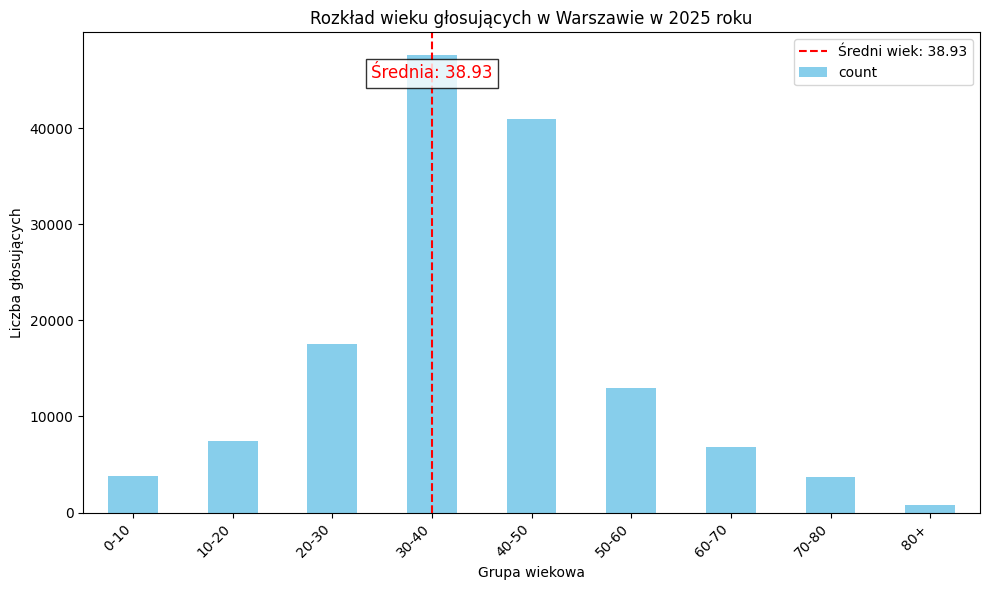

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista do przechowywania wieku głosujących
ages = []

# Przetwarzanie plików tylko dla Warszawy w roku 2025
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy i roku 2025
    if meta['unit'] == 'Warszawa' and meta['instance'] == '2025':
        for vote_data in votes.values():
            try:
                age = int(vote_data['age'])  # Wiek głosującego
                ages.append(age)
            except (KeyError, ValueError):
                continue

# Tworzymy DataFrame, aby łatwiej było pracować z danymi
votes_df = pd.DataFrame(ages, columns=["age"])

# Przekształcamy wiek na kategorie wiekowe (buckets)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, float("inf")]  # Przedziały wiekowe co 10 lat
labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80+"]
votes_df["age_group"] = pd.cut(votes_df["age"], bins=bins, labels=labels, right=False)

# Liczba głosujących w poszczególnych grupach wiekowych
age_group_counts = votes_df["age_group"].value_counts().sort_index()

# Obliczanie średniego wieku
average_age = votes_df["age"].mean()

# Rysowanie wykresu
plt.figure(figsize=(10, 6))
age_group_counts.plot(kind="bar", color="skyblue")
plt.title("Rozkład wieku głosujących w Warszawie w 2025 roku")
plt.xlabel("Grupa wiekowa")
plt.ylabel("Liczba głosujących")

# Dodanie przerywanej czerwonej linii z średnim wiekiem
plt.axvline(
    x=average_age // 10,  # Określamy, gdzie dodać linię (w odpowiednim przedziale)
    color="red",
    linestyle="--",
    label=f"Średni wiek: {average_age:.2f}",
)

# Dodanie tekstu na wykresie z wartością średniego wieku
plt.text(
    average_age // 10,
    max(age_group_counts) * 0.95,
    f"Średnia: {average_age:.2f}",
    color="red",
    fontsize=12,
    ha="center",
    bbox=dict(facecolor="white", alpha=0.8),
)

# Obracanie etykiet na osi X, żeby były czytelne
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()

# Pokazanie wykresu
plt.show()



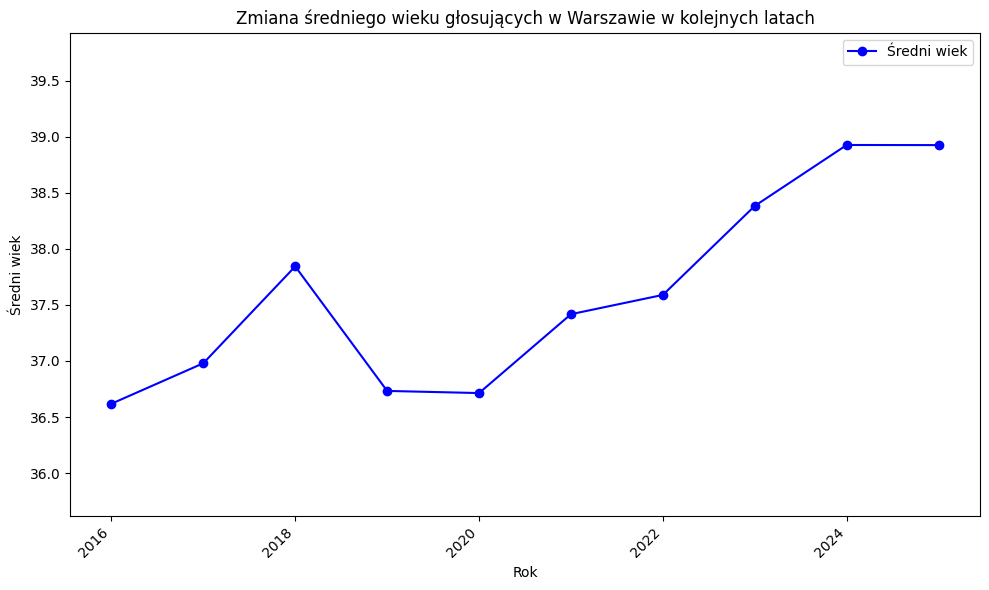

In [109]:
# Słownik do przechowywania wieku głosujących dla każdego roku
ages_by_year = defaultdict(list)

# Przetwarzanie plików dla wszystkich lat
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        year = int(meta['instance']) - 1  # Rok głosowania
        for vote_data in votes.values():
            try:
                age = int(vote_data['age'])  # Wiek głosującego
                ages_by_year[year].append(age)
            except (KeyError, ValueError):
                continue

# Obliczanie średniego wieku dla każdego roku
average_ages = {year: sum(ages) / len(ages) if ages else 0 for year, ages in ages_by_year.items()}

# Rysowanie wykresu zmiany średniego wieku w różnych latach
plt.figure(figsize=(10, 6))
plt.plot(list(average_ages.keys()), list(average_ages.values()), marker='o', color='blue', label='Średni wiek')

# Dostosowanie skali osi Y
plt.ylim(min(average_ages.values()) - 1, max(average_ages.values()) + 1)  # Zmniejszamy zakres osi Y

# Dodanie opisu
plt.title("Zmiana średniego wieku głosujących w Warszawie w kolejnych latach")
plt.xlabel("Rok")
plt.ylabel("Średni wiek")
plt.xticks(rotation=45, ha='right')

# Pokazanie wykresu
plt.legend()
plt.tight_layout()
plt.show()

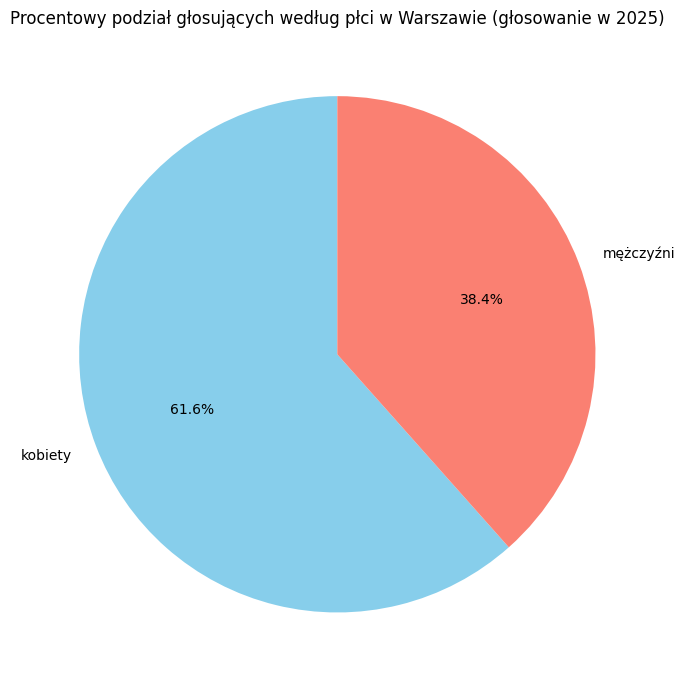

In [113]:
import matplotlib.pyplot as plt

# Słowniki do przechowywania liczby mężczyzn i kobiet
gender_counts = {'F': 0, 'M': 0}  # Zakładając, że 'K' to kobieta, a 'M' to mężczyzna

# Przetwarzanie plików tylko dla Warszawy
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        for vote_data in votes.values():
            try:
                gender = vote_data['sex']  # Płeć głosującego (załóżmy, że 'K' = kobieta, 'M' = mężczyzna)
                if gender in gender_counts:
                    gender_counts[gender] += 1
            except (KeyError, ValueError):
                continue

# Obliczanie procentowego podziału
total_votes = sum(gender_counts.values())
gender_percentages = {gender: (count / total_votes) * 100 for gender, count in gender_counts.items()}

# Wykres kołowy (Pie chart)
plt.figure(figsize=(7, 7))
plt.pie(gender_percentages.values(), labels=["kobiety", "mężczyźni"], autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title("Procentowy podział głosujących według płci w Warszawie (głosowanie w 2025)")
plt.tight_layout()

# Pokazanie wykresu
plt.show()


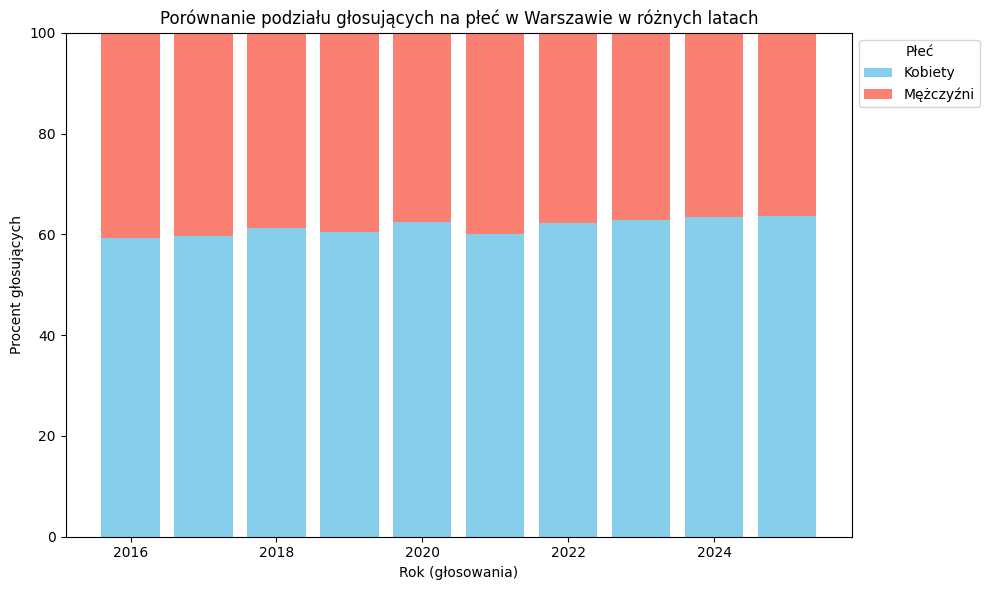

In [122]:
# Słowniki do przechowywania liczby mężczyzn i kobiet dla każdego roku
gender_counts_by_year = defaultdict(lambda: {'F': 0, 'M': 0})

# Przetwarzanie plików dla wszystkich lat
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        year = int(meta['instance']) - 1   # Rok głosowania
        for vote_data in votes.values():
            try:
                gender = vote_data['sex']  # Płeć głosującego (zakładamy, że 'K' = kobieta, 'M' = mężczyzna)
                if gender in gender_counts_by_year[year]:
                    gender_counts_by_year[year][gender] += 1
            except (KeyError, ValueError):
                continue

# Obliczanie procentowego podziału dla każdego roku
gender_percentages_by_year = {}
for year, counts in gender_counts_by_year.items():
    total_votes = sum(counts.values())
    gender_percentages_by_year[year] = {gender: (count / total_votes) * 100 for gender, count in counts.items()}

# Rysowanie wykresu porównującego podział płci w różnych latach
plt.figure(figsize=(10, 6))

# Dodajemy dane dla każdego roku
for year, percentages in gender_percentages_by_year.items():
    plt.bar(year, percentages['F'], color='skyblue', label='Kobiety' if year == 2025 else "")
    plt.bar(year, percentages['M'], bottom=percentages['F'], color='salmon', label='Mężczyźni' if year == 2025 else "")

# Dodanie opisu
plt.title("Porównanie podziału głosujących na płeć w Warszawie w różnych latach")
plt.xlabel("Rok (głosowania)")
plt.ylabel("Procent głosujących")
plt.ylim(0, 100)  # Skala od 0 do 100%

# Dodanie legendy
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Płeć")
plt.tight_layout()

# Pokazanie wykresu
plt.show()

In [126]:
# Słowniki do przechowywania liczby głosów dla papieru i internetu
voting_methods = {'paper': 0, 'internet': 0}

# Przetwarzanie plików tylko dla Warszawy w 2026 roku
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy w roku 2026
    if meta['unit'] == 'Warszawa' and meta['instance'] == '2026':
        for vote_data in votes.values():
            try:
                voting_method = vote_data['voting_method']  # Metoda głosowania (papier/internet)
                if voting_method in voting_methods:
                    voting_methods[voting_method] += 1
            except (KeyError, ValueError):
                continue

# Obliczanie całkowitej liczby głosów
total_votes = sum(voting_methods.values())

# Obliczanie procentowego podziału głosów na papier i internet
voting_percentages = {method: (count / total_votes) * 100 for method, count in voting_methods.items()}

# Wypisywanie wyników
for method in voting_methods:
    count = voting_methods[method]
    percentage = voting_percentages[method]
    print(f"{method.capitalize()}: {count} głosów ({percentage:.2f}%)")


Paper: 852 głosów (0.45%)
Internet: 190064 głosów (99.55%)


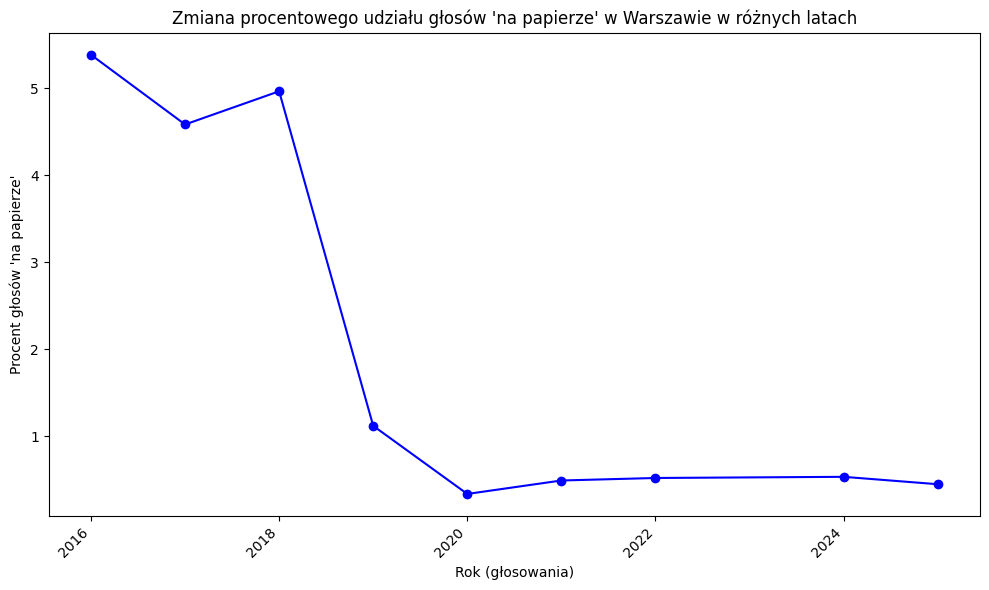

In [129]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Słownik do przechowywania liczby głosów dla papieru i internetu w każdym roku
paper_votes_by_year = defaultdict(int)
total_votes_by_year = defaultdict(int)

# Przetwarzanie plików dla wszystkich lat
for records in all_files.values():
    meta = records[0]
    votes = records[2]  # Głosowanie (trzecia sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        year = int(meta['instance']) - 1  # Rok głosowania
        for vote_data in votes.values():
            try:
                voting_method = vote_data['voting_method']  # Metoda głosowania (papier/internet)
                if voting_method == 'paper':
                    paper_votes_by_year[year] += 1
                total_votes_by_year[year] += 1
            except (KeyError, ValueError):
                continue

# Obliczanie procentowego podziału głosów na papier w każdym roku
paper_percentage_by_year = {
    year: (paper_votes_by_year[year] / total_votes_by_year[year]) * 100
    for year in paper_votes_by_year
}

# Rysowanie wykresu zmiany procentowego udziału głosów "na papierze"
plt.figure(figsize=(10, 6))
plt.plot(list(paper_percentage_by_year.keys()), list(paper_percentage_by_year.values()), marker='o', color='blue')

# Dodanie opisu
plt.title("Zmiana procentowego udziału głosów 'na papierze' w Warszawie w różnych latach")
plt.xlabel("Rok (głosowania)")
plt.ylabel("Procent głosów 'na papierze'")
plt.xticks(rotation=45, ha="right")

# Pokazanie wykresu
plt.tight_layout()
plt.show()


In [135]:
category_mapping = {
    "edukacja": "education",
    "komunikacja publiczna i drogi": "public transit and roads",
    "komunikacja/drogi": "public transit and roads",
    "kultura": "culture",
    "ochrona środowiska": "environmental protection",
    "zieleń i ochrona środowiska": "environmental protection",
    "pomoc społeczna": "welfare",
    "przestrzeń publiczna": "public space",
    "sport": "sport",
    "sport i infrastruktura sportowa": "sport",
    "zdrowie": "health",
    "zieleń miejska": "urban greenery",
    "bezpieczeństwo": "security",
    "infrastruktura": "infrastructure",
    "społeczeństwo": "society",
    "infrastruktura rowerowa": "bicycle infrastructure",
    "tereny zielone i ochrona środowiska": "environmental protection",
    "infrastruktura komunalna i bezpieczeństwo": "municipal infrastructure and security",
    "infrastruktura drogowa i komunikacja": "public transit and roads",
    "sport i rekreacja": "sport and recreation",
    "kultura i dziedzictwo": "culture",
    "zdrowie i pomoc społeczna": "health and welfare",
    "inne": None,
    "edukacja, dzieci i młodzież": "education, children and youth",
    "drogi/komunikacja": "public transit and roads",
    "kultura i sztuka": "culture",
    "edukacja i nauka": "education and science",
    "integracja i wzmacnianie wspólnoty": "community building",
    "komunikacja publiczna i infrastruktura drogowa": "public transit and roads",
    "zieleń i natura": "nature and greenery",
    "ochrona środowiska i zwierzęta": "environmental protection",
}

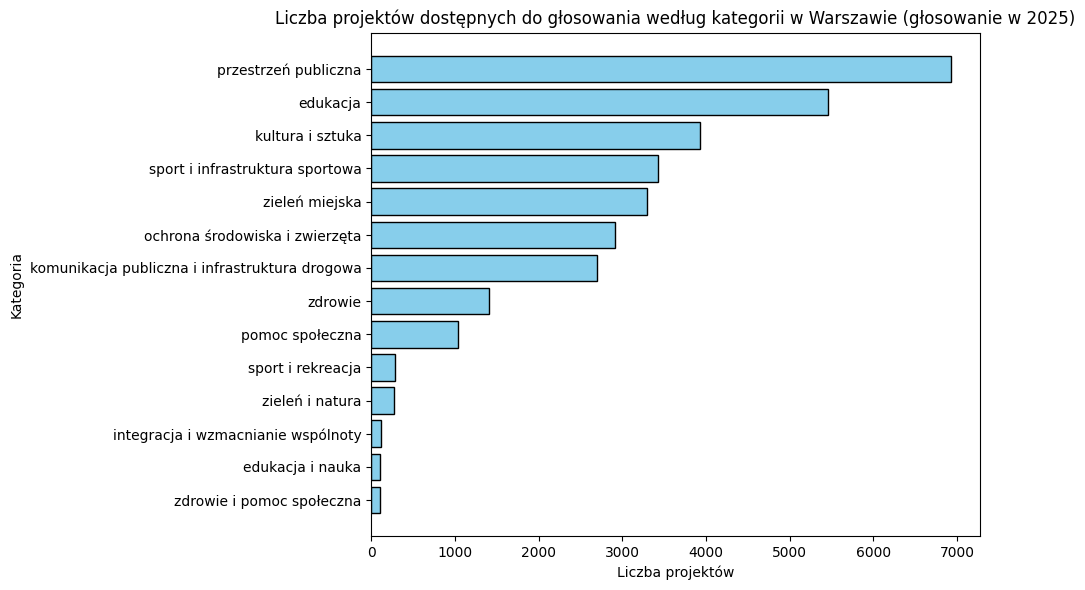

In [149]:
# Odwracamy mapowanie: klucze i wartości zamieniamy miejscami
reversed_category_mapping = {v: k for k, v in category_mapping.items() if v}

# Słownik do przechowywania liczby projektów w każdej kategorii
category_counts = defaultdict(int)

# Przetwarzanie plików dla wszystkich lat
for records in all_files.values():
    meta = records[0]
    projects = records[1]  # Projekty (druga sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        for project_data in projects.values():
            try:
                categories = project_data['category']  # Kategoria projektu
                if isinstance(categories, str):
                    categories = categories.split(",")  # Jeśli kategorie są oddzielone przecinkami, dzielimy je na osobne
                for category in categories:
                    category = category.strip()  # Usuwamy zbędne spacje
                    if category:  # Ignorujemy puste kategorie
                        mapped_category = reversed_category_mapping.get(category, category)  # Mapowanie na kategorię angielską
                        category_counts[mapped_category] += 1
            except (KeyError, ValueError):
                continue

# Sortowanie kategorii według liczby projektów w porządku malejącym
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1])

# Przygotowanie posortowanej listy kategorii i ich wartości
category_names, category_values = zip(*sorted_categories)

# Rysowanie wykresu słupkowego dla liczby projektów w każdej kategorii
plt.figure(figsize=(10, 6))
plt.barh(category_names, category_values, color="skyblue", edgecolor="black")
plt.title("Liczba projektów dostępnych do głosowania według kategorii w Warszawie (głosowanie w 2025)")
plt.xlabel("Liczba projektów")
plt.ylabel("Kategoria")
plt.tight_layout()

# Pokazanie wykresu
plt.show()

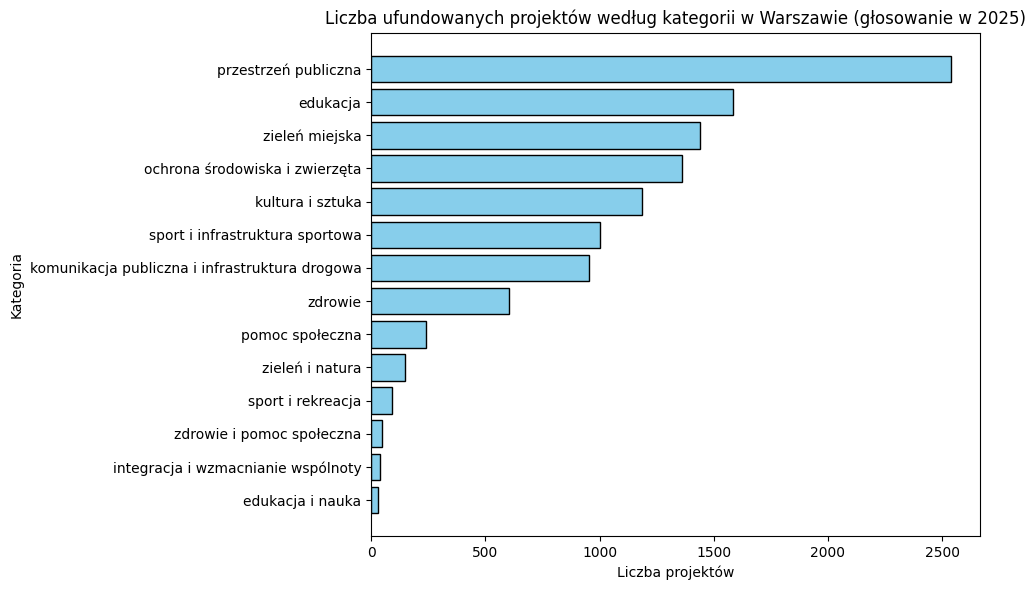

In [153]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Odwracamy mapowanie: klucze i wartości zamieniamy miejscami
reversed_category_mapping = {v: k for k, v in category_mapping.items() if v}

# Słownik do przechowywania liczby projektów w każdej kategorii
category_counts = defaultdict(int)

# Przetwarzanie plików dla wszystkich lat
for records in all_files.values():
    meta = records[0]
    projects = records[1]  # Projekty (druga sekcja)

    # Sprawdzanie, czy dane dotyczą Warszawy
    if meta['unit'] == 'Warszawa':
        for project_data in projects.values():
            try:
                # Sprawdzamy, czy projekt jest ufundowany (selected == "1")
                if project_data['selected'] == "1":  # Tylko projekty ufundowane
                    categories = project_data['category']  # Kategoria projektu
                    if isinstance(categories, str):
                        categories = categories.split(",")  # Jeśli kategorie są oddzielone przecinkami, dzielimy je na osobne
                    for category in categories:
                        category = category.strip()  # Usuwamy zbędne spacje
                        if category:  # Ignorujemy puste kategorie
                            mapped_category = reversed_category_mapping.get(category, category)  # Mapowanie na kategorię angielską
                            category_counts[mapped_category] += 1
            except (KeyError, ValueError):
                continue

# Sortowanie kategorii według liczby projektów w porządku malejącym
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1])

# Przygotowanie posortowanej listy kategorii i ich wartości
category_names, category_values = zip(*sorted_categories)

# Rysowanie wykresu słupkowego dla liczby projektów w każdej kategorii (tylko ufundowane projekty)
plt.figure(figsize=(10, 6))
plt.barh(category_names, category_values, color="skyblue", edgecolor="black")
plt.title("Liczba ufundowanych projektów według kategorii w Warszawie (głosowanie w 2025)")
plt.xlabel("Liczba projektów")
plt.ylabel("Kategoria")
plt.tight_layout()

# Pokazanie wykresu
plt.show()


In [151]:
# Funkcja do obliczenia liczby ufundowanych projektów i procentu dla roku 2026
def calculate_funded_projects(all_files, description_prefix, year="2026"):
    total_projects = 0
    funded_projects = 0

    # Przetwarzanie plików
    for records in all_files.values():
        meta = records[0]
        projects = records[1]  # Projekty (druga sekcja)

        # Sprawdzanie, czy dane dotyczą Warszawy w roku 2026
        if meta['unit'] == 'Warszawa' and str(meta['instance']) == year and meta['description'].startswith(description_prefix):
            total_projects += len(projects)
            for project_data in projects.values():
                try:
                    # Sprawdzanie, czy projekt został wybrany (selected = 1)
                    if project_data['selected'] == "1":  # Status "selected" = 1 oznacza ufundowany projekt
                        funded_projects += 1
                except KeyError:
                    continue

    # Obliczanie procentu
    if total_projects > 0:
        funded_percentage = (funded_projects / total_projects) * 100
    else:
        funded_percentage = 0

    return funded_projects, total_projects, funded_percentage

# Obliczanie dla roku 2026 i ogólnych danych
funded_all, total_all, percentage_all = calculate_funded_projects(all_files, "")
print(f"Rok 2026: Ogólnie ufundowano {funded_all} z {total_all} projektów ({percentage_all:.2f}%)")

# Obliczanie dla projektów ogólnomiejskich (municipal) w roku 2026
funded_municipal, total_municipal, percentage_municipal = calculate_funded_projects(all_files, "Municipal", year="2026")
print(f"Rok 2026, Ogólnomiejskie: ufundowano {funded_municipal} z {total_municipal} projektów ({percentage_municipal:.2f}%)")

# Obliczanie dla projektów w dzielnicach (District) w roku 2026
funded_district, total_district, percentage_district = calculate_funded_projects(all_files, "District", year="2026")
print(f"Rok 2026, Dzielnice: ufundowano {funded_district} z {total_district} projektów ({percentage_district:.2f}%)")

# Obliczanie dla projektów lokalnych (Local) w roku 2026
funded_local, total_local, percentage_local = calculate_funded_projects(all_files, "Local", year="2026")
print(f"Rok 2026, Projekty lokalne: ufundowano {funded_local} z {total_local} projektów ({percentage_local:.2f}%)")


Rok 2026: Ogólnie ufundowano 551 z 1373 projektów (40.13%)
Rok 2026, Ogólnomiejskie: ufundowano 17 z 83 projektów (20.48%)
Rok 2026, Dzielnice: ufundowano 156 z 424 projektów (36.79%)
Rok 2026, Projekty lokalne: ufundowano 378 z 866 projektów (43.65%)
